# American and Bermudan Option pricer

In [1]:
# Packages used
import numpy as np
import matplotlib.pyplot as plt
from scipy import odr
from helper import *
import keras
from scipy.stats import norm
import pandas as pd
import seaborn as sns
from tqdm import tqdm

In [2]:
def GBM_exact(T, S, sigma, r, M):
    S_all = []
    S_all.append(S)
    dt = T/M
    Zm = np.random.normal(size=M)
    for i in range(M-1):
        S_all.append(S_all[i] * np.exp((r-0.5*sigma**2) * dt + sigma * np.sqrt(dt) * Zm[i])) 
    return S_all

## Simulations Run with Data from paper

American option should be priced at .1144

In [3]:
# Parameters
K=1.1; M=4; r=.06; realizations=8; T=M

# Matrix
path_matrix = np.array([
[1.00, 1.09, 1.08, 1.34],
[1.00, 1.16, 1.26, 1.54],
[1.00, 1.22, 1.07, 1.03],
[1.00, 0.93, 0.97, 0.92],
[1.00, 1.11, 1.56, 1.52],
[1.00, .76, 0.77, 0.90],
[1.00, 0.92, 0.84, 1.01],
[1.00, 0.88, 1.22, 1.34]])

In [4]:
# Generate cash flows under Longstaff-Schwarz
[cash_flows, somehting_else]= value_option_schwarz(T,M,K,path_matrix, r, realizations, option="put")

# Discount cash flows
for time in range(cash_flows.shape[1]):
    cash_flows[:,time]*=np.exp(-r*time)
print(f'Price of American Option is: {np.sum(cash_flows[0:])/realizations}')

Price of American Option is: 0.11443433004505696


In [5]:
cash_flows_test = value_option_schwarz_test(M,K,path_matrix, r, realizations, option="put")

# Discount cash flows
for time in range(cash_flows.shape[1]):
    cash_flows_test[:,time]*=np.exp(-r*time)
print(f'Price of American Option is: {np.sum(cash_flows_test[0:])/realizations}')    

Price of American Option is: 0.11443433004505696


In [6]:
# Unit test Bermudian pricer by giving it same amount of exericse options as American
exercise_dates = [1,2,3,4]
cash_flow_bermudan = value_option_bermudan(M, K, path_matrix, r, realizations, exercise_dates, option="put")

for time in range(cash_flow_bermudan.shape[1]):
    cash_flow_bermudan[:,time] *= np.exp(-r*time)
print(f'Price of Bermudan Option is: {np.sum(cash_flow_bermudan[0:])/realizations}')    

Price of Bermudan Option is: 0.11561153571203728


In [7]:
# Fewer exercise points should lead to lower option price
exercise_dates = [2,3,4]
cash_flow_bermudan = value_option_bermudan(M, K, path_matrix, r, realizations, exercise_dates, option="put")

for time in range(cash_flow_bermudan.shape[1]):
    cash_flow_bermudan[:,time] *= np.exp(-r*time)
print(f'Price of Bermudan Option is: {np.sum(cash_flow_bermudan[0:])/realizations}')    

Price of Bermudan Option is: 0.056380739270260896


In [8]:
# Unit test Bermudian pricer by giving it same amount of exericse options as American
exercise_dates = [1,2,3,4]
cash_flow_bermudan = value_option_bermudan(M, K, path_matrix, r, realizations, exercise_dates, option="put")

for time in range(cash_flow_bermudan.shape[1]):
    cash_flow_bermudan[:,time] *= np.exp(-r*time)
print(f'Price of Bermudan Option is: {np.sum(cash_flow_bermudan[0:])/realizations}')  

Price of Bermudan Option is: 0.11561153571203728


## Simulation based on GBM

In [9]:
# Variables used
T = M = N = 4
K = 1.1
S = 1
sigma = 0.2
r = 0.06
realizations = 2000

repititions = 30
europeans = np.zeros(repititions)
americans = np.zeros(repititions)
dt = T/M


In [10]:
repititions = 30
europeans = np.zeros(repititions)
americans = np.zeros(repititions)
dt = T/M


for i in range(repititions):
    s_all = np.array([np.array(GBM_exact(T, S, sigma, r, M)) for x in range(realizations)])
    europeans[i] = np.sum(np.maximum(0,K-s_all[:,-1]))/realizations * np.exp(-r * T)
    [option_cash_flow, cash_flows] = value_option_schwarz(T,M,K,s_all, r, realizations,order=2,option="put")
    
    for time in range(option_cash_flow.shape[1]):
        option_cash_flow[:,time]*=np.exp(-r*(time*dt))
    americans[i] =  np.sum(option_cash_flow)/realizations

<AxesSubplot:>

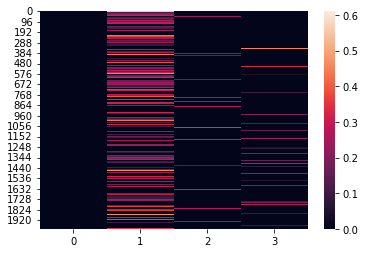

In [11]:
sns.heatmap(cash_flows)

In [12]:
np.mean(europeans)

0.08971985221818492

In [13]:
np.std(americans)/np.sqrt(repititions)

0.0005788308620589761

In [14]:
payoffs = np.maximum(K-s_all[:,:],0)
dt = T/M

for time in range(payoffs.shape[1]):
    payoffs[:,time]*=np.exp(-r*(dt*time))
    
max_payoffs = []
for path in range(payoffs.shape[0]):
    max_payoffs.append(max(payoffs[path]))
    
np.mean(max_payoffs)

0.19537047267703847

In [15]:
np.mean(americans)

0.12060065221395323

In [16]:
np.std(americans)

0.0031703872012986242

### Neural Net

In [17]:
from keras.models import Sequential
from keras.layers import Dense, Input
import keras.optimizers as opt
from keras.constraints import Constraint
from keras import backend as keras_backend
import tensorflow as tf

In [18]:
'''
Pricing options using Black-Scholes
'''

def d1(S0, r, delta, t0, t, k, sigma):
    return 1/(sigma*np.sqrt(t-t0)) * (np.log(S0/k) + (r-delta+(sigma**2)/2)*(t-t0))

def d2(S0, r, delta, t0, t, k, sigma):
    return 1/(sigma*np.sqrt(t-t0)) * (np.log(S0/k) + (r-delta-(sigma**2)/2)*(t-t0))

def BSMcall(S0, r, delta, t0, t, k, sigma):
    return S0*np.exp(-delta*(t-t0))*norm.cdf(d1(S0, r, delta, t0, t, k, sigma)) - k*np.exp(-r*(t-t0))*norm.cdf(d2(S0, r, delta, t0, t, k, sigma))

def BSMPut(S0, r, delta, t0, t, k, sigma):
    return k*np.exp(-r*(t-t0))*norm.cdf(-d2(S0, r, delta, t0, t, k, sigma)) - S0*np.exp(-delta*(t-t0))*norm.cdf(-d1(S0, r, delta, t0, t, k, sigma))

def fwdValue(S0, r, delta, t0, t, k):
    return S0*np.exp(-delta*(t-t0)) - k*np.exp(-r*(t-t0))

def depositPV(t0, t, p):
    return p*np.exp(-r*(t-t0))

In [38]:
'''
Price a portfolio
'''

def identify_positions(wt_list, strike_list):
    positions = np.where(np.logical_and(wt_list>0, strike_list<0), "C", 
                        np.where(np.logical_and(wt_list>0, strike_list>=0), "F", 
                                 np.where(np.logical_and(wt_list<0, strike_list>0), "P", "N")))
    
    pos = (np.array(np.unique(positions, return_counts=True)).T)
    no_of_pos_dict = {"C":0 , "P":0, "F":0 , "N":0 }
    
    for i in range(0, len(pos[:,0])):
        no_of_pos_dict[pos[i,0]] = int(pos[i,1])

    return no_of_pos_dict["C"], no_of_pos_dict["P"], no_of_pos_dict["F"], no_of_pos_dict["N"], positions

def find_instr_params(nn_strikes, inner_wts, outer_wts, outer_bias, positions, s_init):
    strikes_array = np.where(positions == "F", 
                            - s_init * np.divide(np.abs(nn_strikes), np.abs(inner_wts)), 
                            s_init * np.divide(np.abs(nn_strikes), np.abs(inner_wts)))
    deposit = outer_bias * s_init
    pfl_weights = np.multiply(np.abs(inner_wts), outer_wts)
    
    return strikes_array, deposit, pfl_weights

def static_hedge_value_nn(stock_vec, strike_list, positions, pfl_wts, deposit, 
                          s_init, r, delta, sigma, t):
    strks = strike_list.reshape(1,-1)
    non_neg_strks = np.abs(strks)
    wts = pfl_wts.reshape(1,-1)
    pos = positions.reshape(1,-1)
    c_wt =   np.multiply(wts, np.where(pos=="C", 1, 0))
    p_wt =   np.multiply(wts, np.where(pos=="P", 1, 0))
    f_wt =   np.multiply(wts, np.where(pos=="F", 1, 0))
    
    stock_vec = stock_vec.reshape(-1,1)
    #nn_static_hedge_value = np.sum(c_wt*(np.maximum(stock_vec-non_neg_strks,0)) + 
    #                         p_wt*(np.maximum(non_neg_strks-stock_vec,0)) + 
    #                         f_wt*(stock_vec-strks), axis=1) + deposit
    
    portfolio_price_vec = np.sum(c_wt*BSMcall(stock_vec, r, delta, 0, t, non_neg_strks, sigma) 
    + p_wt*BSMPut(stock_vec, r, delta, 0, t, non_neg_strks, sigma) 
    + f_wt*fwdValue(stock_vec, r, delta, 0, t, strks), axis=1) + deposit * np.exp(-r*t)
    
    pvt0_nn = np.sum(c_wt*BSMcall(s_init, r, delta, 0, t, non_neg_strks, sigma) + 
                     p_wt*BSMPut(s_init, r, delta, 0, t, non_neg_strks, sigma) + 
                     f_wt*fwdValue(s_init, r, delta, 0, t, strks), axis=1) + deposit * np.exp(-r*t)
    
    return portfolio_price_vec, pvt0_nn

In [32]:
'''
A class that fits neural network to payoff paths of a Bermudan Option
'''

class neural_bermudan_fitter:
    def __init__(self, r, sigma, stock_paths, K, dates, option="put", ittol=10, T=1, nodes=10, epochs=10, pre_trained_model=None, delta=0, learning_rate=.001):
        self.stock_paths = stock_paths
        self.K = K
        assert all(earlier > later for earlier, later in zip(dates, dates[1:])), 'the dates should be in descending order'
        self.dates = dates
        
        self.T=T
        self.r = r
        self.sigma = sigma
        self.option = option.lower()
        self.N = len(self.stock_paths)
        self.M = len(self.dates)
        self.num_stoch_movements = len(self.stock_paths[0])
        self.nodes = nodes
        self.epochs = epochs
        self.ittol=ittol
        
        self.evaluate_final()
        
        #step 3 of Jain
        self.beta = np.random.uniform(size=(self.N,1))
        self.nnets = []
        self.positions = []
        if pre_trained_model:
            self.nnets.append(pre_trained_model)
        else:
            self.learning_rate = learning_rate
            self.setup_network()
            
        self.s_init = stock_paths[0,0]
        self.V = np.zeros(self.N)
        self.Q_hat = np.zeros(self.N)
        self.callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=30)
        self.histories = []
        self.opt_val = np.zeros((self.nodes, len(self.dates), self.N))
        self.delta=delta
        
    def evaluate_final(self):
        # step 2 of algorithm in Jain paper
        if self.option == 'call':
            self.h = tf.maximum(self.stock_paths[:,-1] - self.K,0)
        else:
            self.h = tf.maximum(self.K - self.stock_paths[:,-1],0)
            
    def setup_network(self):
        nn = Sequential([
                    Input(shape=(1)),
                    Dense(self.nodes,activation='relu',trainable=True, kernel_initializer = 'random_uniform'),
                    Dense(1,activation='linear',trainable=True, kernel_initializer=keras.initializers.RandomUniform(minval=-0.01, maxval=0.01, seed=None))
                    ])
        nn.compile(tf.optimizers.Adam(learning_rate=self.learning_rate), loss='mean_squared_error')
        
        if self.option=="call":
            Y_train = np.maximum(self.stock_paths[:,-1] - self.K, 0)
        else:
            Y_train = np.maximum(self.K - self.stock_paths[:,-1], 0)

        X_train = self.stock_paths[:,-1]
        
        callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=30)
        history = nn.fit(X_train.reshape(-1,1), Y_train.reshape(-1,1), epochs=500, verbose=0, callbacks=[callback])
        if history.history['loss'][-1] > 1:
            print("warning. NN didn't converge")
        
        self.nnets.append(nn)
    
    def copy_network(self):
        new_model = keras.models.clone_model(self.nnets[-1])
        new_model.compile(tf.optimizers.Adam(learning_rate=self.learning_rate), loss='mean_squared_error')
        new_model.set_weights(self.nnets[-1].get_weights())
        self.nnets.append(new_model)
        
    def price_portfolio(self,m):
        inner_wts = np.array(self.nnets[-1].layers[0].get_weights()[0]).reshape(-1)
        nn_strikes_orig = np.array(self.nnets[-1].layers[0].get_weights()[1]).reshape(-1)
        outer_wts = np.array(self.nnets[-1].layers[1].get_weights()[0]).reshape(-1)
        outer_bias = np.array(self.nnets[-1].layers[1].get_weights()[1]).reshape(-1)
        
        #Genererate Derivative contract equivalents from weights
        #global no_of_calls, no_of_puts, no_of_fwds, nulls, positions, strike_arry, deposit, pfl_wts
        no_of_calls, no_of_puts, no_of_fwds, no_of_nulls, positions = identify_positions(inner_wts, nn_strikes_orig)
        self.positions.append(positions)
        strike_array, deposit, pfl_wts = find_instr_params(nn_strikes_orig, inner_wts, outer_wts, outer_bias, positions, self.s_init)
        deposit_list = np.array([deposit for i in range(0, self.nodes)])
        params = [strike_array.reshape(self.nodes,1), deposit_list.reshape(self.nodes,1), pfl_wts.reshape(self.nodes,1)]

        #Generate Hedge Values
        #stock_vec = np.array(df_sim_stocks_test.iloc[-1,:]).reshape(-1)
        self.Q_hat, self.pvt0_nn = static_hedge_value_nn(self.stock_paths[:,self.dates[m+1]], strike_array, positions, pfl_wts, deposit, 
                                                               self.s_init, self.r, self.delta, self.sigma, self.t)
        
    def run_pricing_simulation(self):  
        # time to maturity for european options
        self.t = 1
        for m in range(len(self.dates)-2):
            #step 5
            self.price_portfolio(m)
            
            self.copy_network()
            self.fit_model(m)
            
        self.price_portfolio(m)
        self.pvt0_nn*=np.exp(self.r*-1)
                  
            
    def fit_model(self,m):
        Y_train = np.zeros(self.N)
        if self.option=='call':
            self.h = np.maximum(0, self.stock_paths[:,self.dates[m+1]] - self.K)
            for i, value in enumerate(self.h):
                if value > self.Q_hat[i]:
                    Y_train[i] = value
                else:
                    Y_train[i] = self.Q_hat[i]
            #print(Y_train)
        else:
            self.h = np.maximum(0, self.K - self.stock_paths[:,self.dates[m+1]])
            try:
                for i, value in enumerate(self.h):
                    if value > self.Q_hat[i]:
                        Y_train[i] = value
                    else:
                        Y_train[i] = self.Q_hat[i]
            except:
                print(self.h)
            #print(Y_train)
            
        X_train = np.array(self.stock_paths[:,self.dates[m+1]])
        self.histories.append(self.nnets[-1].fit(X_train.reshape(-1,1), Y_train.reshape(-1,1), epochs=self.epochs, callbacks=[self.callback], verbose=0))
        i=0
        while self.histories[-1].history['loss'][-1] > 10 and i< self.ittol:
            i+=1
            print("warning. NN didn't converge")
            print(f"loss: {self.histories[-1].history['loss'][-1]}, time: {date}")
            self.histories.append(self.nnets[-1].fit(X_train.reshape(-1,1), Y_train.reshape(-1,1), epochs=self.epochs, callbacks=[self.callback], verbose=0))


In [21]:
# Pre train a NN at the standard payoffs

In [22]:
nodes = 20
dates = [3,2,1,0]

In [39]:
nf = neural_bermudan_fitter(r, sigma, s_all,  K, dates, epochs = 1000, nodes=nodes)

In [40]:
nf.run_pricing_simulation()

C:\Users\JWant\AppData\Local\Temp\ipykernel_4152\2176255774.py:6: RuntimeWarning: divide by zero encountered in true_divide
  return 1/(sigma*np.sqrt(t-t0)) * (np.log(S0/k) + (r-delta+(sigma**2)/2)*(t-t0))
C:\Users\JWant\AppData\Local\Temp\ipykernel_4152\2176255774.py:9: RuntimeWarning: divide by zero encountered in true_divide
  return 1/(sigma*np.sqrt(t-t0)) * (np.log(S0/k) + (r-delta-(sigma**2)/2)*(t-t0))


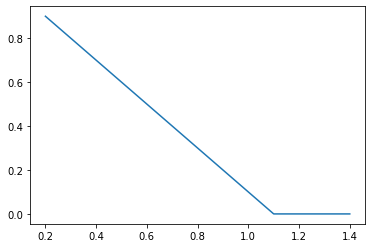

In [41]:
plt.plot(np.linspace(0.2,1.4,1000), nf.nnets[0].predict(np.linspace(0.2,1.4,1000)))

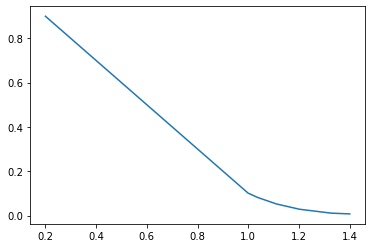

In [42]:
plt.plot(np.linspace(0.2,1.4,1000), nf.nnets[1].predict(np.linspace(0.2,1.4,1000)))

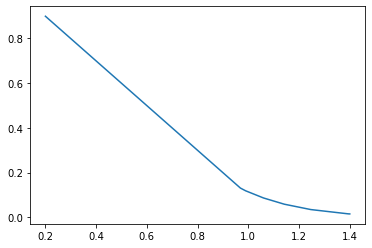

In [43]:
plt.plot(np.linspace(0.2,1.4,1000), nf.nnets[-1].predict(np.linspace(0.2,1.4,1000)))

In [45]:
nf.pvt0_nn

array([0.11446431])

In [146]:
# study different Ks
realizations = 1000
repititions = 3
americans = np.zeros(repititions)
dt = T/M
S=1
Ks=[1,1.1,1.2]
europeans = []
lower_bounds = []
upper_bounds = []
nn_values=[]
s_init=S
no_of_options=nodes
delta=0
t=1

for K in Ks:
    europeans.append(BSM_put(S, K, r, sigma, T))
    for i in range(repititions):
        s_all = np.array([np.array(GBM_exact(T, S, sigma, r, M)) for x in range(realizations)])
        [option_cash_flow, cash_flows] = value_option_schwarz(T,M,K,s_all, r, realizations,order=2,option="put")
        payoffs = np.maximum(K-s_all[:,:],0)
        dt = T/M

        for time in range(option_cash_flow.shape[1]):
            payoffs[:,time]*=np.exp(-r*(dt*time))
            option_cash_flow[:,time]*=np.exp(-r*(time*dt))
            
        max_payoffs = []
        for path in range(payoffs.shape[0]):
            max_payoffs.append(max(payoffs[path]))
            
        americans[i] =  np.sum(option_cash_flow)/realizations
            
        nf = neural_bermudan_fitter(r, sigma, s_all,  K, dates, epochs = 1000, nodes=nodes)
        nf.run_pricing_simulation()
        
        nn_values.append(nf.pvt0_nn)
        
    lower_bounds.append(np.mean(americans))
    upper_bounds.append(np.mean(max_payoffs))

0
[0.05166004]


C:\Users\JWant\AppData\Local\Temp\ipykernel_12744\3438939615.py:9: RuntimeWarning: divide by zero encountered in true_divide
  return 1/(sigma*np.sqrt(t-t0)) * (np.log(S0/k) + (r-delta-(sigma**2)/2)*(t-t0))
C:\Users\JWant\AppData\Local\Temp\ipykernel_12744\3438939615.py:6: RuntimeWarning: divide by zero encountered in true_divide
  return 1/(sigma*np.sqrt(t-t0)) * (np.log(S0/k) + (r-delta+(sigma**2)/2)*(t-t0))


1
[0.08445483]
0
[0.05171586]
1
[0.07665118]
0
[0.05172074]
1
[0.0771289]
0
[0.10031404]
1
[0.13685185]
0
[0.10029129]
1
[0.13908725]
0
[0.10031426]
1
[0.13852095]
0
[0.16425315]
1
[0.21975611]
0
[0.16520632]
1
[0.21880735]
0
[0.1652094]
1
[0.19777653]


In [149]:
nn_together = []
for i in range(repititions):
    nn_together.append(np.mean(nn_values[i*repititions:(i+1)*repititions]))

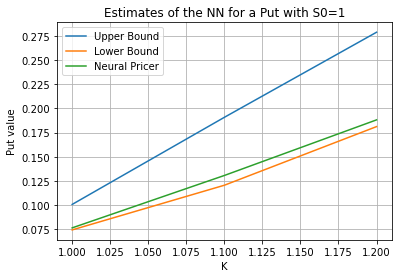

In [151]:
plt.plot(Ks, upper_bounds, label='Upper Bound')
plt.plot(Ks, lower_bounds, label='Lower Bound')
plt.plot(Ks, nn_together, label = 'Neural Pricer')
plt.legend()
plt.title("Estimates of the NN for a Put with S0=1")
plt.ylabel("Put value")
plt.xlabel("K")
plt.grid()
plt.savefig("figures/NN_pricer.pdf", dpi=300)

## Convergence when # nodes increases

In [39]:
#Study different # nodes
S=1
K=1.1
Nnodes = np.arange(5,30)
#Nnodes = np.linspace(5,30,6)
nn_values=[]
s_init=S
#no_of_options=nodes
delta=0
t=1

In [ ]:
s_all = np.array([np.array(GBM_exact(T, S, sigma, r, M)) for x in range(realizations)])

In [40]:
results_convergence = []

for nodes in tqdm(Nnodes):

    
    nodes = int(nodes)
    # Set up neural network
    nn = Sequential([
            Input(shape=(1)),
            Dense(nodes,activation='relu',trainable=True, kernel_initializer = 'random_uniform'),
            Dense(1,activation='linear',trainable=True, kernel_initializer=keras.initializers.RandomUniform(minval=-0.01, maxval=0.01, seed=None))
            ])
    nn.compile(tf.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')
    
    # Train die nn
    Y_train = np.maximum(K - s_all[:,-1], 0)
    X_train = s_all[:,-1]

    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=30)
    history = nn.fit(X_train.reshape(-1,1), Y_train.reshape(-1,1), epochs=500, verbose=0, callbacks=[callback])
    if history.history['loss'][-1] > 1:
        print("warning. NN didn't converge")

    dates = [3,2,1,0]

    # fit
    nf = neural_bermudan_fitter(r, sigma, s_all,  K, dates, epochs = 1000, nodes=nodes)

    # run simulation
    nf.run_pricing_simulation()
    
    # Save price
    results_convergence.append(nf.pvt0_nn)

  0%|                                                                                           | 0/25 [00:00<?, ?it/s]C:\Users\sebas\AppData\Local\Temp/ipykernel_17776/2176255774.py:9: RuntimeWarning: divide by zero encountered in true_divide
  return 1/(sigma*np.sqrt(t-t0)) * (np.log(S0/k) + (r-delta-(sigma**2)/2)*(t-t0))
C:\Users\sebas\AppData\Local\Temp/ipykernel_17776/2176255774.py:6: RuntimeWarning: divide by zero encountered in true_divide
  return 1/(sigma*np.sqrt(t-t0)) * (np.log(S0/k) + (r-delta+(sigma**2)/2)*(t-t0))
100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [07:03<00:00, 16.93s/it]


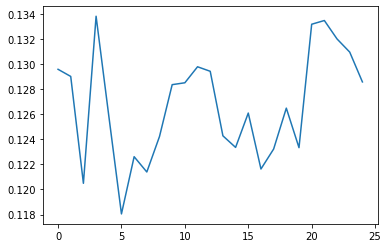

In [41]:
plt.plot(results_convergence)

In [59]:
upperbound = 0.18855579222624316
lowerbound_data = np.array([0.11840553, 0.12466009, 0.11907022, 0.12558082, 0.11715823,
       0.12534869, 0.11960652, 0.12400716, 0.1217654 , 0.12127061,
       0.12065544, 0.12228015, 0.12087237, 0.11960958, 0.12043162,
       0.1177108 , 0.12041161, 0.11808278, 0.12043451, 0.12290068,
       0.12051659, 0.11865335, 0.12375626, 0.12129248, 0.12487578,
       0.12111814, 0.12393027, 0.11984866, 0.11680912, 0.11815887])
lowerbound_mean = np.mean(lowerbound_data)
lowerbound_err = 1.96 * np.std(lowerbound_data)/np.sqrt(len(lowerbound_data))

In [66]:
lowerbound_err

0.0008808458720489553

Text(0, 0.5, 'V ')

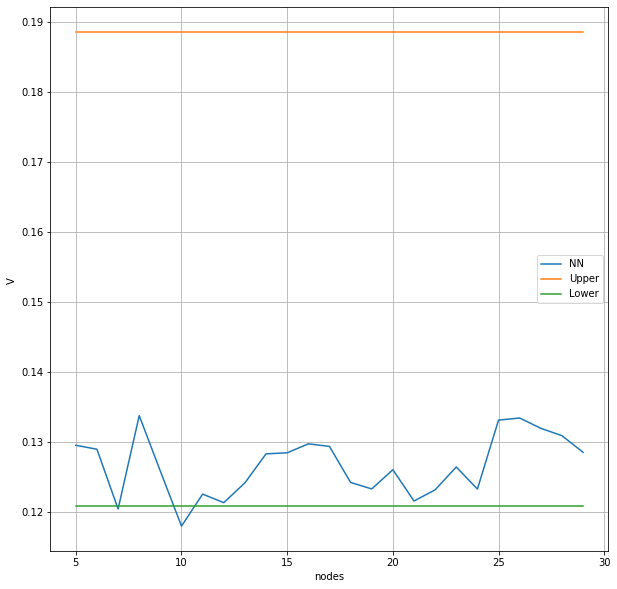

In [62]:
plt.figure(figsize=(10,10))
plt.plot(Nnodes,results_convergence, label = 'NN')
plt.plot(Nnodes, [upperbound] * len(Nnodes), label = 'Upper')
plt.plot(Nnodes, [lowerbound] *len(Nnodes), label = 'Lower')
plt.grid()
plt.legend()
plt.xlabel('nodes')
plt.ylabel('V ')

Text(0, 0.5, 'V - $\\hat{V}$')

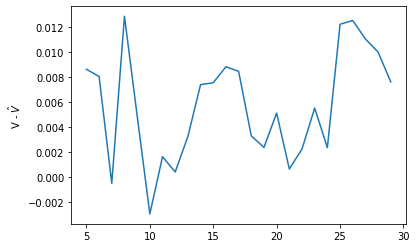

In [65]:
plt.plot(Nnodes, results_convergence - lowerbound_mean)
plt.ylabel('V - $\hat{V}$')

In [54]:
results_convergence

[array([0.12957806]),
 array([0.12900983]),
 array([0.12048882]),
 array([0.13380892]),
 array([0.1258798]),
 array([0.11804745]),
 array([0.12260964]),
 array([0.1213901]),
 array([0.12421918]),
 array([0.128354]),
 array([0.12850401]),
 array([0.12977983]),
 array([0.12941985]),
 array([0.12427486]),
 array([0.12335014]),
 array([0.1260893]),
 array([0.12162803]),
 array([0.12322135]),
 array([0.12648125]),
 array([0.1233302]),
 array([0.13317103]),
 array([0.13346831]),
 array([0.13199832]),
 array([0.13094922]),
 array([0.12857291])]

In [58]:
(0.129-lowerbound)/0.129 * 100

6.221645219638247

In [56]:
lowerbound

0.12097407766666667

In [148]:
#Study different # nodes
S=1
K=1.1
Nnodes = np.arange(5,30)
nn_values=[]
s_init=S
no_of_options=nodes
delta=0
t=1

for nodes in Nnodes:
    no_of_options=nodes
    s_all = np.array([np.array(GBM_exact(T, S, sigma, r, M)) for x in range(realizations)])
    nf = neural_bermudan_fitter(r, sigma, s_all,  K, dates, epochs = 1000, nodes=nodes)
    nf.run_pricing_simulation()
    #Neural Network Weights
    inner_wts = np.array(nf.nnets[-1].layers[0].get_weights()[0]).reshape(-1)
    nn_strikes_orig = np.array(nf.nnets[-1].layers[0].get_weights()[1]).reshape(-1)
    outer_wts = np.array(nf.nnets[-1].layers[1].get_weights()[0]).reshape(-1)
    #if (outer_bias_init == "no bias"):
    #    outer_bias = np.array([0]).reshape(-1)
    #else:
    outer_bias = np.array(nf.nnets[-1].layers[1].get_weights()[1]).reshape(-1)

    #Genererate Derivative contract equivalents from weights
    global no_of_calls, no_of_puts, no_of_fwds, nulls, positions, strike_arry, deposit, pfl_wts
    no_of_calls, no_of_puts, no_of_fwds, no_of_nulls, positions = identify_positions(inner_wts, nn_strikes_orig)
    strike_array, deposit, pfl_wts = find_instr_params(nn_strikes_orig, inner_wts, outer_wts, outer_bias, positions, s_init)
    deposit_list = np.array([deposit for i in range(0, no_of_options)])
    params = [strike_array.reshape(no_of_options,1), deposit_list.reshape(no_of_options,1), pfl_wts.reshape(no_of_options,1)]

    #Generate Hedge Values
    stock_vec = s_all[:,0]
    #stock_vec = np.array(df_sim_stocks_test.iloc[-1,:]).reshape(-1)
    nn_static_hedge_value, pvt0_nn = static_hedge_value_nn(stock_vec, strike_array, positions, pfl_wts, deposit, 
                                                           s_init, r, delta, sigma, t)
    nn_values.append(np.sum(nn_static_hedge_value)/len(nn_static_hedge_value))

C:\Users\JWant\AppData\Local\Temp\ipykernel_12656\559481366.py:2: RuntimeWarning: divide by zero encountered in true_divide
  return 1/(sigma*np.sqrt(t-t0)) * (np.log(S0/k) + (r-delta+(sigma**2)/2)*(t-t0))
C:\Users\JWant\AppData\Local\Temp\ipykernel_12656\559481366.py:5: RuntimeWarning: divide by zero encountered in true_divide
  return 1/(sigma*np.sqrt(t-t0)) * (np.log(S0/k) + (r-delta-(sigma**2)/2)*(t-t0))


In [140]:
nf.positions

[array(['P', 'C', 'N', 'P', 'N', 'P', 'N', 'N', 'N', 'N', 'P', 'P', 'P',
        'P', 'N', 'N', 'N', 'N', 'N', 'N'], dtype='<U1')]

In [162]:
T = M = N = 4
K = 1.1
S = 1
sigma = 0.2
r = 0.06
realizations = 2000

repititions = 30
upper_bound = []
americans = np.zeros(repititions)
dt = T/M


for i in range(repititions):
    s_all = np.array([np.array(GBM_exact(T, S, sigma, r, M)) for x in range(realizations)])
    europeans[i] = np.sum(np.maximum(0,K-s_all[:,-1]))/realizations * np.exp(-r * T)
    payoffs = np.maximum(K-s_all[:,:],0)
    dt = T/M
    [option_cash_flow, cash_flows] = value_option_schwarz(T,M,K,s_all, r, realizations,order=2,option="put")
    
    for time in range(option_cash_flow.shape[1]):
        option_cash_flow[:,time]*=np.exp(-r*(time*dt))
        payoffs[:,time]*=np.exp(-r*(dt*time))
    americans[i] =  np.sum(option_cash_flow)/realizations
    
    max_payoffs = []
    for path in range(payoffs.shape[0]):
        max_payoffs.append(max(payoffs[path]))

    upper_bound.append(np.mean(max_payoffs))

0.18855579222624316

In [153]:
americans

array([0.11840553, 0.12466009, 0.11907022, 0.12558082, 0.11715823,
       0.12534869, 0.11960652, 0.12400716, 0.1217654 , 0.12127061,
       0.12065544, 0.12228015, 0.12087237, 0.11960958, 0.12043162,
       0.1177108 , 0.12041161, 0.11808278, 0.12043451, 0.12290068,
       0.12051659, 0.11865335, 0.12375626, 0.12129248, 0.12487578,
       0.12111814, 0.12393027, 0.11984866, 0.11680912, 0.11815887])

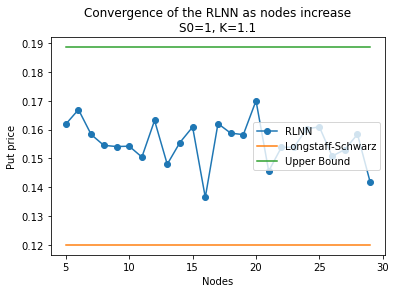

In [171]:
plt.plot(Nnodes,nn_values, label="RLNN",marker='o')
plt.plot(Nnodes, np.repeat(np.mean(americans), len(Nnodes)), label="Longstaff-Schwarz")
plt.plot(Nnodes, np.repeat(np.mean(upper_bound), len(Nnodes)), label="Upper Bound")
plt.legend()
plt.ylabel("Put price")
plt.xlabel("Nodes")
plt.title("Convergence of the RLNN as nodes increase\nS0=1, K=1.1")
plt.savefig("figures/convergence_nodes.pdf",dpi=300)

In [37]:
# Figures for presentation

In [95]:
# Pre trained NN

In [96]:
Y_train = np.maximum(K - s_all[:,-1], 0)

X_train = s_all[:,-1]

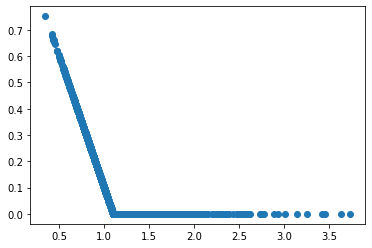

In [97]:
plt.scatter(X_train, Y_train)

In [98]:
S = np.linspace(0.1,2,20)
V = np.zeros(S.shape)

V = nn.predict(np.array(S).reshape(-1,1))

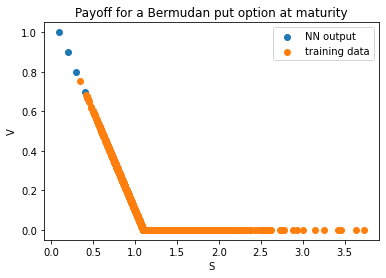

In [99]:
plt.scatter(S,V, label="NN output")
plt.scatter(X_train, Y_train, label="training data")
plt.legend()
plt.xlabel("S")
plt.ylabel("V")
plt.title("Payoff for a Bermudan put option at maturity")
plt.savefig("figures/put_at_maturity_NN.jpg", dpi=300)

In [100]:
# NN payoff at later times

In [101]:
Y_train = np.maximum(K - s_all[:,-1], 0)

X_train = s_all[:,-1]

In [102]:
m=2
V = np.zeros(len(nf.stock_paths[:,nf.dates[m]]))

for s in range(len(nf.stock_paths[:,nf.dates[m]])): 
    V[s] = np.sum(nf.opt_val[:,m,s])

h = np.maximum(0, nf.K - nf.stock_paths[:,dates[m]])

for i, value in enumerate(h):
    if value > V[i]:
        Y_train[i] = value
    else:
        Y_train[i] = V[i]
#Y_train = np.maximum(nf.h, V)

X_train = np.array(nf.stock_paths[:,dates[m]]).reshape(1,-1)

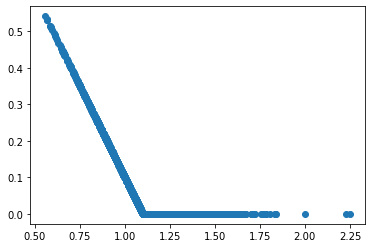

In [103]:
plt.scatter(X_train, Y_train)

In [104]:
V = nf.nnets[m].predict(np.array(S).reshape(-1,1))

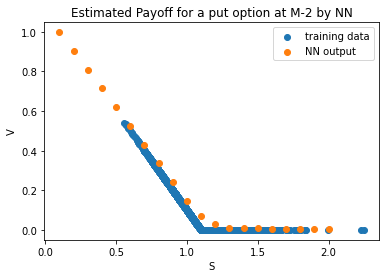

In [105]:
plt.scatter(X_train, Y_train, label="training data")
plt.scatter(S,V, label="NN output")
#plt.scatter(X_train, Y_train, label="training data")
plt.legend()
plt.xlabel("S")
plt.ylabel("V")
plt.title(f"Estimated Payoff for a put option at M-{m} by NN")
plt.savefig(f"figures/M-{m}_payoff_NN.jpg", dpi=300)